In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# pca
from sklearn.decomposition import PCA

# svm, kfold, evaluation 
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, KFold, GridSearchCV

# performance
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# computational time
import time

# CNN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary # summary model

# utils
from tqdm import tqdm_notebook as tqdm
from matplotlib.colors import Normalize
import os

In [2]:
# fix seed for reproducibility
np.random.seed(seed=42)
torch.manual_seed(42)

In [3]:
TRAIN_SIZE = 5000
TEST_SIZE = 1000
BATCH_SIZE = 4
EPOCH = 15

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# use a portion of the dataset
trainset_5000 = torch.utils.data.Subset(trainset, range(TRAIN_SIZE))
testset_1000 = torch.utils.data.Subset(testset, range(TEST_SIZE))

trainloader = torch.utils.data.DataLoader(trainset_5000, batch_size=TRAIN_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_1000, batch_size=TEST_SIZE,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X_train, y_train = iter(trainloader).next()
X_test, y_test = iter(testloader).next()

X_train, y_train, X_test, y_test = X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy()
X_train, X_test = X_train.reshape(TRAIN_SIZE, -1), X_test.reshape(TEST_SIZE, -1), 
print(X_train.shape, y_test.shape)

(5000, 3072) (1000,)


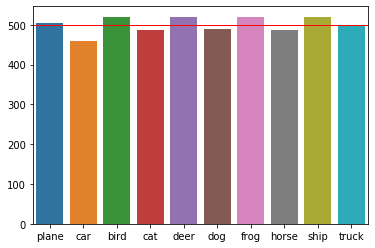

In [5]:
occurrence = np.array([y_train.tolist().count(i) for i in range(10)])
fig, ax = plt.subplots()
ax.axhline(occurrence.mean(), color='red', linewidth=1)
sns.barplot(classes, occurrence)

## Task 1

In [6]:
def pca_feature_reduction(X, n_components=None):
    pca = PCA(n_components)
    X_reduced = pca.fit_transform(X.reshape((X.shape[0],-1)))
    print(pca.n_components_)
    return X_reduced, pca

In [7]:
X_reduced_10, pca_10 = pca_feature_reduction(X_train, .10)
X_reduced_30, pca_30 = pca_feature_reduction(X_train, .30)
X_reduced_50, pca_50 = pca_feature_reduction(X_train, .50)
X_reduced_70, pca_70 = pca_feature_reduction(X_train, .70)
X_reduced_100, pca_100 = pca_feature_reduction(X_train) # if n_components is not set all components are kept
# X_origin_100 = np.array(X_train.reshape(500,-1))

X_reduced_test_10 = pca_10.transform(X_test.reshape((X_test.shape[0],-1)))
X_reduced_test_30 = pca_30.transform(X_test.reshape((X_test.shape[0],-1)))
X_reduced_test_50 = pca_50.transform(X_test.reshape((X_test.shape[0],-1)))
X_reduced_test_70 = pca_70.transform(X_test.reshape((X_test.shape[0],-1)))
X_reduced_test_100 = pca_100.transform(X_test.reshape((X_test.shape[0],-1)))

1
2
4
14
3072


In [8]:
# reduced_imgs.shape
approximation_list = [j.inverse_transform(i)/ 2 + 0.5 for i, j in [(X_reduced_10, pca_10), (X_reduced_30, pca_30),
                                                                  (X_reduced_50, pca_50), (X_reduced_70, pca_70),
                                                                  (X_reduced_100, pca_100)]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


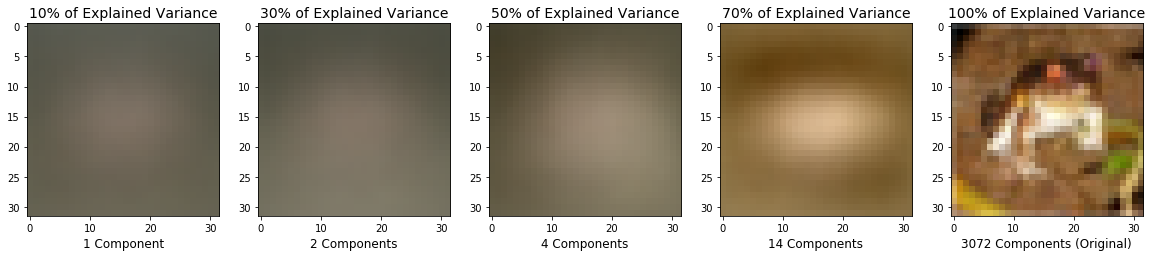

In [9]:
plt.figure(figsize=(20,4))
plt.subplot(1, 5, 1)
# plot_image(approximation_list[0][0].reshape(3,32,32), 10, X_reduced_10.shape[1])
plt.imshow(np.transpose(approximation_list[0][0].reshape(3,32,32), (1, 2, 0)))
plt.xlabel('%d Component' % X_reduced_10.shape[1], fontsize = 12)
plt.title('10% of Explained Variance', fontsize = 14)

plt.subplot(1, 5, 2)
plt.imshow(np.transpose(approximation_list[1][0].reshape(3,32,32), (1, 2, 0)))
plt.xlabel('%d Components' % X_reduced_30.shape[1], fontsize = 12)
plt.title('30% of Explained Variance', fontsize = 14);

plt.subplot(1, 5, 3)
plt.imshow(np.transpose(approximation_list[2][0].reshape(3,32,32), (1, 2, 0)))
plt.xlabel('%d Components' % X_reduced_50.shape[1], fontsize = 12)
plt.title('50% of Explained Variance', fontsize = 14);

plt.subplot(1, 5, 4)
plt.imshow(np.transpose(approximation_list[3][0].reshape(3,32,32), (1, 2, 0)))
plt.xlabel('%d Components' % X_reduced_70.shape[1], fontsize = 12)
plt.title('70% of Explained Variance', fontsize = 14);

plt.subplot(1, 5, 5)
plt.imshow(np.transpose(approximation_list[4][0].reshape(3,32,32), (1, 2, 0)))
plt.xlabel('%d Components (Original)' % X_reduced_100.shape[1], fontsize = 12)
plt.title('100% of Explained Variance', fontsize = 14);

## Task 2

In [10]:
def compute_score(y_true, y_pred, class_f1=True):
    result = {}
    result['acc'] = accuracy_score(y_true, y_pred)
    if class_f1:
        f1 = f1_score(y_true, y_pred, average=None)
        result = {**result, **dict(zip(classes, f1))}
    result['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
    result['precision'] = precision_score(y_true, y_pred, average='weighted')
    result['recall'] = recall_score(y_true, y_pred, average='weighted')

    return result

In [11]:
print('C_range:', 2**-5, '~', 2**15)
print('gamma_range:', 2**-15, '~', 2**3)

cv = KFold(n_splits=10, random_state=42) # CHANGE

C_range: 0.03125 ~ 32768
gamma_range: 3.0517578125e-05 ~ 8


In [12]:
# find best C for linear kernel
# for simplicity
def linear_search_cv(X_train, y_train, kernel, param_name, param_range, cv):
    linear = GridSearchCV(svm.SVC(kernel=kernel), param_grid={param_name: param_range}, 
                             cv=cv, verbose=2, n_jobs=-1)
    linear.fit(X_train, y_train)
    
    scores = linear.cv_results_['mean_test_score'].reshape(len(param_range))
    
    n_features = X_train.shape[1]
    label = str(n_features) + ' feature' if n_features == 1 else str(n_features) + ' features'
    plt.xticks(np.arange(len(param_range)), param_range, rotation=45)
    sns.lineplot(x=range(len(param_range)), y=scores, label=label)
    
    return linear

In [ ]:
C_range_linear = np.logspace(-4, 0, 5)
linear_search_cv(X_train, y_train, 'linear', 'C', C_range_linear, cv)
linear_search_cv(X_reduced_10, y_train, 'linear', 'C', C_range_linear, cv)
linear_search_cv(X_reduced_30, y_train, 'linear', 'C', C_range_linear, cv)
linear_search_cv(X_reduced_50, y_train, 'linear', 'C', C_range_linear, cv)
linear_search_cv(X_reduced_70, y_train, 'linear', 'C', C_range_linear, cv)
linear_search_cv(X_reduced_100, y_train, 'linear', 'C', C_range_linear, cv)
print()

In [13]:
def svm_main(X_train, X_test, test_name, df, linear_params):
    svm_result = {}
    svm_result['name'] = test_name
    svm_result['n_features'] = str(int(X_train.shape[1]))
    
    clf = svm.SVC(**linear_params)
    
    # fit on whole training data
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    svm_result['fit_time'] = end - start
    
    # test on testing data
    start = time.time()
    y_test_pred = clf.predict(X_test)
    end = time.time()
    svm_result['pred_time'] = end - start
    
    eval_score = compute_score(y_test, y_test_pred)
    svm_result = {**svm_result, **eval_score}
    print(test_name, "done!")
    return df.append(svm_result, ignore_index=True)

In [14]:
svm_df = pd.DataFrame()
linear_params = {'kernel': 'linear', 'C': 0.001, 'verbose': 1}
svm_df = svm_main(X_reduced_10, X_reduced_test_10, 'linear_10%', svm_df, linear_params)
svm_df = svm_main(X_reduced_30, X_reduced_test_30, 'linear_30%', svm_df, linear_params)
svm_df = svm_main(X_reduced_50, X_reduced_test_50, 'linear_50%', svm_df, linear_params)
svm_df = svm_main(X_reduced_70, X_reduced_test_70, 'linear_70%', svm_df, linear_params)
svm_df = svm_main(X_reduced_100, X_reduced_test_100, 'linear_100%', svm_df, linear_params)

[LibSVM]

/Users/xiaoyun/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xiaoyun/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


linear_10% done!
[LibSVM]

/Users/xiaoyun/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xiaoyun/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


linear_30% done!
[LibSVM]linear_50% done!
[LibSVM]linear_70% done!
[LibSVM]linear_100% done!


In [15]:
svm_df = svm_df[['name', 'n_features', 'acc', 'precision', 'recall', 
                 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'f1_weighted',
                 'fit_time', 'pred_time']]
svm_df

,name,n_features,acc,precision,recall,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,f1_weighted,fit_time,pred_time
0,linear_10%,1,0.173,0.093707,0.173,0.314815,0.000000,0.070175,0.000000,0.080000,0.000000,0.289206,0.000000,0.208202,0.070423,0.108780,0.378837,0.066484
1,linear_30%,2,0.243,0.188061,0.243,0.306452,0.155039,0.189189,0.000000,0.112994,0.225989,0.329268,0.000000,0.301370,0.386441,0.204832,0.376556,0.075434
2,linear_50%,4,0.273,0.246297,0.273,0.338028,0.084034,0.172840,0.018349,0.149425,0.227979,0.347541,0.194286,0.442804,0.372760,0.240834,0.400816,0.072114
3,linear_70%,14,0.330,0.324122,0.330,0.357143,0.355263,0.233010,0.151724,0.248756,0.218182,0.410448,0.256983,0.504000,0.411765,0.318973,0.680076,0.100885
4,linear_100%,3072,0.373,0.373684,0.373,0.371134,0.465409,0.311927,0.215909,0.251366,0.233129,0.444444,0.424581,0.492188,0.436364,0.368572,107.140223,17.328828


### Task 2.2

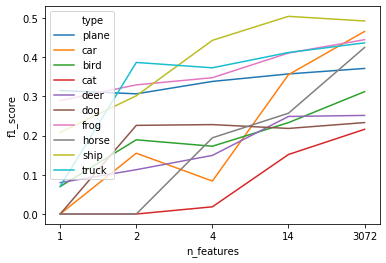

In [16]:
# f1 score for each class
svm_f1_score_df = pd.DataFrame()
for i, n_feature in enumerate(svm_df['n_features'].values):
    for j, type_name in enumerate(classes):
        entry = dict({'n_features': str(n_feature), 'type': type_name, 'f1_score': svm_df[classes].values[i][j]})
        svm_f1_score_df = svm_f1_score_df.append(entry, ignore_index=True)

sns.lineplot(x='n_features', y='f1_score', hue='type', data=svm_f1_score_df, sort=False)

Text(0, 0.5, 'percentage')

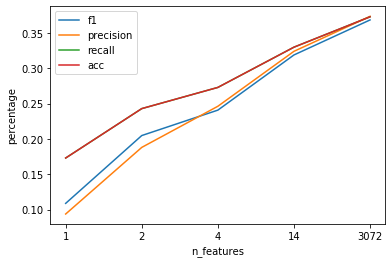

In [19]:
# weighted (acc, f1, precision, recall)
sns.lineplot(x='n_features', y='f1_weighted', data=svm_df, label='f1', sort=False)
sns.lineplot(x='n_features', y='precision', data=svm_df, label='precision', sort=False)
sns.lineplot(x='n_features', y='recall', data=svm_df, label='recall', sort=False)
sns.lineplot(x='n_features', y='acc', data=svm_df, label='acc', sort=False)
plt.ylabel('percentage')

In [20]:
clf = svm.SVC(kernel='linear', C=0.001)
y_test_pred = clf.fit(X_reduced_100, y_train).predict(X_reduced_test_100)
y_score = clf.decision_function(X_reduced_test_100)

In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve

In [22]:
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=range(0,10))

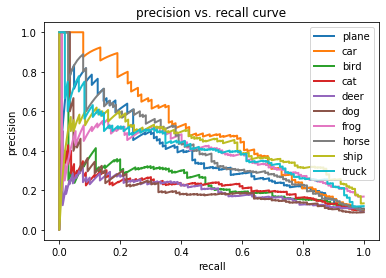

In [23]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=classes[i])

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

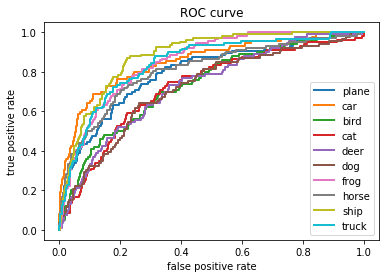

In [24]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label=classes[i])

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))

    sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='.3g')
    plt.title(title)
    print("\n")

Confusion matrix, without normalization




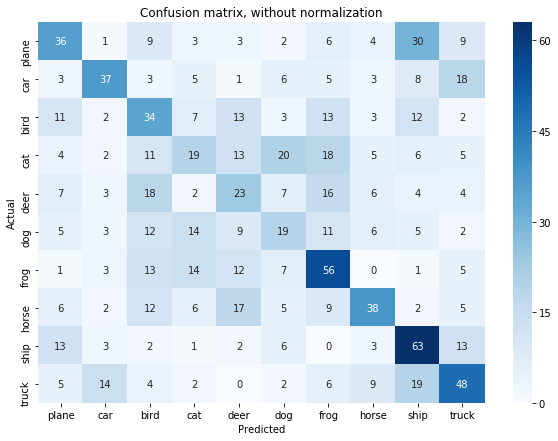

In [26]:
plot_confusion_matrix(y_test, y_test_pred, classes=classes, title='Confusion matrix, without normalization')

Normalized confusion matrix




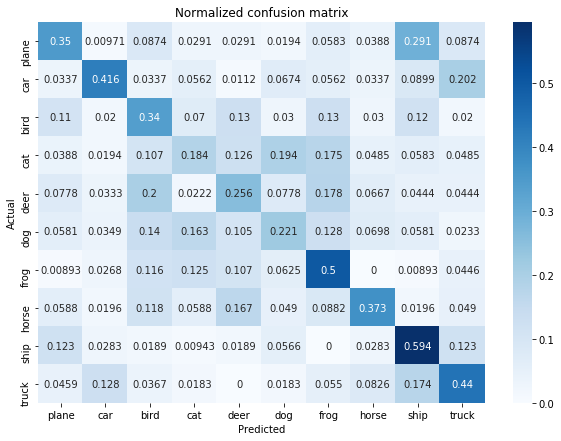

In [27]:
plot_confusion_matrix(y_test, y_test_pred, classes=classes, normalize=True, title='Normalized confusion matrix')

### task 2.3 - poly

In [29]:
# # 8 concurrent workers: 1 hour; 32 workers: 25 mins
poly_degree_range = np.arange(0, 10, 1)
linear = linear_search_cv(X_train, y_train, 'poly', 'degree', poly_degree_range, cv)

In [46]:
best_degree = linear.best_params_
print(best_degree)

{'degree': 1}


In [36]:
def grid_search_cv(X_train, y_train, kernel, param_grid, cv):
    grid = GridSearchCV(svm.SVC(kernel=kernel), param_grid=param_grid, cv=cv, verbose=6, n_jobs=-1)
    
    grid.fit(X_train, y_train)
    
    print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))
    return grid

def plot_heatmap(scores):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.show()

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [37]:
print('C_range:', 2**-5, '~', 2**15)
print('gamma_range:', 2**-15, '~', 2**3)
C_range = np.logspace(-2, 4, 7)
gamma_range = np.logspace(-5, 1, 7)
param_grid = dict(gamma=gamma_range, C=C_range)

C_range: 0.03125 ~ 32768
gamma_range: 3.0517578125e-05 ~ 8


In [38]:
poly_grid = grid_search_cv(X_train, y_train, 'poly', param_grid, cv=cv)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 61.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 174.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 250.6min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 279.8min finished


The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.372


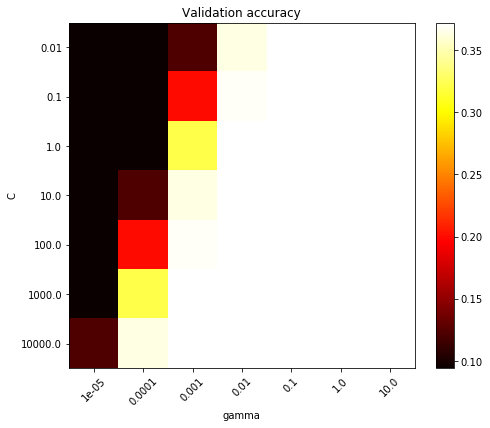

In [39]:
plot_heatmap(poly_grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range)))

In [45]:
poly_params = {'kernel': 'poly', 'verbose': 10, **best_degree, **poly_grid.best_params_}

print(poly_params)
svm_df = svm_main(X_train, X_test, 'poly', svm_df, poly_params)

{'kernel': 'poly', 'verbose': 10, 'degree': 1, 'C': 1.0, 'gamma': 0.01}
[LibSVM]poly_delete done!


In [ ]:
svm_df

### Task 2.3 rbf

In [47]:
rbf_grid = grid_search_cv(X_train, y_train, 'rbf', param_grid, cv=cv)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 64.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 112.3min
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 174.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 248.7min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 282.3min finished


The best parameters are {'C': 10.0, 'gamma': 0.001} with a score of 0.447


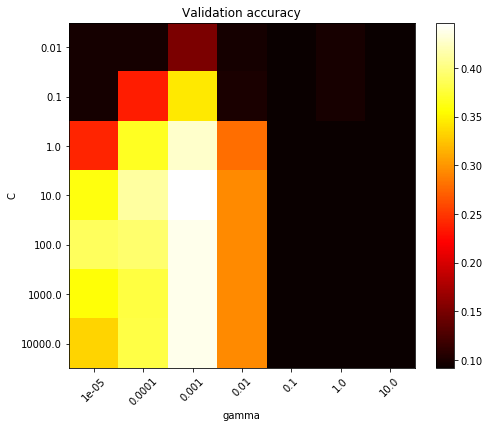

In [48]:
plot_heatmap(rbf_grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range)))

In [49]:
rbf_params = {'kernel': 'rbf', 'verbose': 10, **rbf_grid.best_params_}
print(rbf_params)
svm_df = svm_main(X_train, X_test, 'rbf', svm_df, rbf_params)

{'kernel': 'poly', 'verbose': 10, 'degree': 1, 'C': 1.0, 'gamma': 0.01}
[LibSVM]rbf done!


In [50]:
svm_df

,name,n_features,acc,precision,recall,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,f1_weighted,fit_time,pred_time
0,linear_10%,1,0.173,0.093707,0.173,0.314815,0.000000,0.070175,0.000000,0.080000,0.000000,0.289206,0.000000,0.208202,0.070423,0.108780,0.378837,0.066484
1,linear_30%,2,0.243,0.188061,0.243,0.306452,0.155039,0.189189,0.000000,0.112994,0.225989,0.329268,0.000000,0.301370,0.386441,0.204832,0.376556,0.075434
2,linear_50%,4,0.273,0.246297,0.273,0.338028,0.084034,0.172840,0.018349,0.149425,0.227979,0.347541,0.194286,0.442804,0.372760,0.240834,0.400816,0.072114
3,linear_70%,14,0.330,0.324122,0.330,0.357143,0.355263,0.233010,0.151724,0.248756,0.218182,0.410448,0.256983,0.504000,0.411765,0.318973,0.680076,0.100885
4,linear_100%,3072,0.373,0.373684,0.373,0.371134,0.465409,0.311927,0.215909,0.251366,0.233129,0.444444,0.424581,0.492188,0.436364,0.368572,107.140223,17.328828
5,poly_delete,3072,0.355,0.357822,0.355,0.394495,0.500000,0.310502,0.211009,0.259459,0.152866,0.403756,0.389474,0.497817,0.389744,0.354613,102.133489,17.071837
6,rbf,3072,0.453,0.455825,0.453,0.480392,0.554913,0.457399,0.284360,0.319149,0.260870,0.523810,0.505263,0.612766,0.478049,0.452319,139.674481,18.058136


In [51]:
# add to final results
results = svm_df[['name', 'n_features', 'acc', 'f1_weighted', 'precision', 'recall', 'fit_time', 'pred_time']]
results 

,name,n_features,acc,f1_weighted,precision,recall,fit_time,pred_time
0,linear_10%,1,0.173,0.108780,0.093707,0.173,0.378837,0.066484
1,linear_30%,2,0.243,0.204832,0.188061,0.243,0.376556,0.075434
2,linear_50%,4,0.273,0.240834,0.246297,0.273,0.400816,0.072114
3,linear_70%,14,0.330,0.318973,0.324122,0.330,0.680076,0.100885
4,linear_100%,3072,0.373,0.368572,0.373684,0.373,107.140223,17.328828
5,poly_delete,3072,0.355,0.354613,0.357822,0.355,102.133489,17.071837
6,rbf,3072,0.453,0.452319,0.455825,0.453,139.674481,18.058136


## Task 3 - CNN

In [52]:
trainloader_cnn = torch.utils.data.DataLoader(trainset_5000, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader_cnn = torch.utils.data.DataLoader(testset_1000, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [53]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

baseline_net = BaselineNet()

In [54]:
print(baseline_net)

BaselineNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [55]:
summary(baseline_net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [74]:
flatten = lambda l: [i for sublist in l for i in sublist]

def cnn_train(net, trainloader, n_epoch, model_path):
    cache_train_loss = []
    cache_train_acc = []
#     step_loss = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(n_epoch):
    
        running_loss = 0.0
        pred_labels = []
        true_labels = []
        for i, data in enumerate(tqdm(trainloader, desc='Training'), 0):
            # get the inputs: data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            pred_labels.append(predicted.tolist())
            true_labels.append(labels.tolist())
            loss.backward()
            
            optimizer.step()
            
            # save loss
            running_loss += loss.item()

        epoch_loss = running_loss / (TRAIN_SIZE/BATCH_SIZE)
        print('epoch ', epoch, 'loss: %.3f', epoch_loss)
        cache_train_loss.append(epoch_loss)
        pred_labels = flatten(pred_labels)
        true_labels = flatten(true_labels)
        
        accuracy = cnn_eval_report(true_labels, pred_labels)
        cache_train_acc.append(accuracy)
        

        # save model to path
        model_name = model_path + '_epoch_%s' % epoch + '.pth'
        torch.save(net.state_dict(), model_name)
    print('Finished Training')

    print((i+1)*4)
    torch.save(net.state_dict(), model_path + '.pth')
    return cache_train_loss, cache_train_acc

In [75]:
def cnn_test(net, model_path, testloader):
    val_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    net.load_state_dict(torch.load(model_path))
    
    pred_labels = []
    true_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            pred_labels.append(predicted.tolist())
            true_labels.append(labels.tolist())
    
    pred_labels = flatten(pred_labels)
    true_labels = flatten(true_labels)
    
    accuracy = cnn_eval_report(true_labels, pred_labels)

    val_loss = val_loss / (TEST_SIZE/BATCH_SIZE)
    return val_loss, accuracy, true_labels, pred_labels

def cnn_eval_report(y_true, y_pred):
    accuracy = (np.array(y_pred) == np.array(y_true)).sum() / len(y_true)
    return accuracy


In [76]:
def cnn_main(name, net, n_epoch, dir_path):
    path = dir_path + '/cifar'
    if not os.path.exists(path):
        os.makedirs(path)
    
    # train
    start = time.time()
    train_loss_list, train_acc_list = cnn_train(net, trainloader_cnn, n_epoch, path)
    end = time.time()
    training_time = end - start
    
    # eval
    print("start evaluating")
    best_acc = 0.0
    best_epoch = 0
    best_preds = []
    val_loss_list, val_acc_list = [], []
    eval_time = []
    for epoch in tqdm(range(n_epoch), desc='Evaluating'):
        model_name = path + '_epoch_%s' % epoch + '.pth'
        start = time.time()
        val_loss, accuracy, true_labels, pred_labels = cnn_test(net, model_name, testloader_cnn)
        end = time.time()
        eval_time.append(end-start)
        if accuracy > best_acc:
            best_epoch = epoch + 1
            best_acc = accuracy
            best_preds = pred_labels
        val_loss_list.append(val_loss)
        val_acc_list.append(accuracy)

    plot_confusion_matrix(true_labels, best_preds, classes=classes, 
                          normalize=True, title='Normalized confusion matrix')
    plt.savefig(dir_path+'cm.png')

    print('Best model found in epoch %d, acc %.3f' % (best_epoch, best_acc))
    mean_eval_time = sum(eval_time) / len(eval_time)
    
    cnn_scores = compute_score(true_labels, best_preds, class_f1=False)
    return ({'name': name, 'n_features': '', 
                'fit_time': training_time, 'pred_time': mean_eval_time, **cnn_scores}, train_loss_list, 
            train_acc_list, val_loss_list, val_acc_list) 


epoch  0 loss: %.3f 2.2918998931884764



epoch  1 loss: %.3f 2.080434964466095



epoch  2 loss: %.3f 1.8588114090442658



epoch  3 loss: %.3f 1.7091492021560668



epoch  4 loss: %.3f 1.602108146095276



epoch  5 loss: %.3f 1.5121794750452042



epoch  6 loss: %.3f 1.43547154276371



epoch  7 loss: %.3f 1.359149331831932



epoch  8 loss: %.3f 1.28409293282032



epoch  9 loss: %.3f 1.2117753650307654



epoch  10 loss: %.3f 1.1369891982078553



epoch  11 loss: %.3f 1.0450778562277556



epoch  12 loss: %.3f 0.9653612709134817



epoch  13 loss: %.3f 0.8877024972438812



epoch  14 loss: %.3f 0.7950006168812513
Finished Training
5000
start evaluating



Normalized confusion matrix


Best model found in epoch 8, acc 0.477


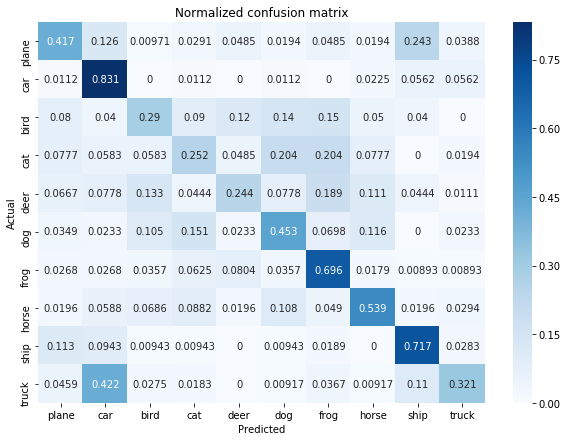

In [81]:
baseline_score, b_train_loss, b_train_acc, b_val_loss, b_val_acc = cnn_main('baseline_cnn', BaselineNet(), 15, './baseline/')

In [110]:
results = results.append(baseline_score, ignore_index=True)

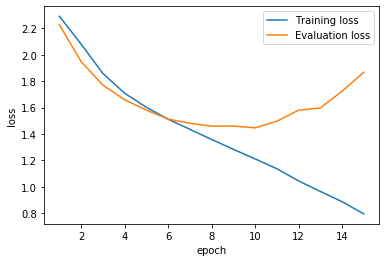

In [111]:
sns.lineplot(x=range(1,len(train_loss)+1), y=b_train_loss, label='Training loss')
sns.lineplot(x=range(1,len(train_loss)+1), y=b_val_loss, label='Evaluation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./baseline/loss.png')

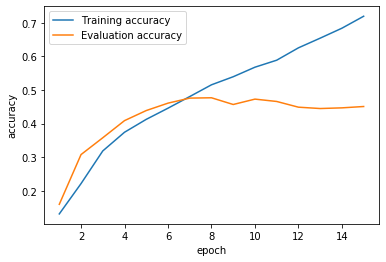

In [112]:
sns.lineplot(x=range(1,len(train_loss)+1), y=b_train_acc, label='Training accuracy')
sns.lineplot(x=range(1,len(train_loss)+1), y=b_val_acc, label='Evaluation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('./baseline/acc.png')

In [115]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 36, 2)
        self.fc1 = nn.Linear(36 * 6 * 6, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 84)
#         self.dropout = nn.Dropout2d(p=0.1)
        self.fc4 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 36 * 6 * 6)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

In [116]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             912
         MaxPool2d-2           [-1, 12, 14, 14]               0
            Conv2d-3           [-1, 36, 13, 13]           1,764
         MaxPool2d-4             [-1, 36, 6, 6]               0
            Linear-5                  [-1, 240]         311,280
            Linear-6                  [-1, 120]          28,920
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 353,890
Trainable params: 353,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 1.35
Estimated Total Size (MB): 1.51
----------------------------------------------------------------



epoch  0 loss: %.3f 2.297711932182312



epoch  1 loss: %.3f 2.143320004749298



epoch  2 loss: %.3f 1.9187208325862886



epoch  3 loss: %.3f 1.7595538454532624



epoch  4 loss: %.3f 1.6338619579315186



epoch  5 loss: %.3f 1.52559809923172



epoch  6 loss: %.3f 1.43404685485363



epoch  7 loss: %.3f 1.3431261762142181



epoch  8 loss: %.3f 1.247419385612011



epoch  9 loss: %.3f 1.138245261979103



epoch  10 loss: %.3f 1.0095759440660477



epoch  11 loss: %.3f 0.8798825031340122



epoch  12 loss: %.3f 0.7493994618773461



epoch  13 loss: %.3f 0.6476186170101166



epoch  14 loss: %.3f 0.5682857152424753
Finished Training
5000
start evaluating



Normalized confusion matrix


Best model found in epoch 10, acc 0.504


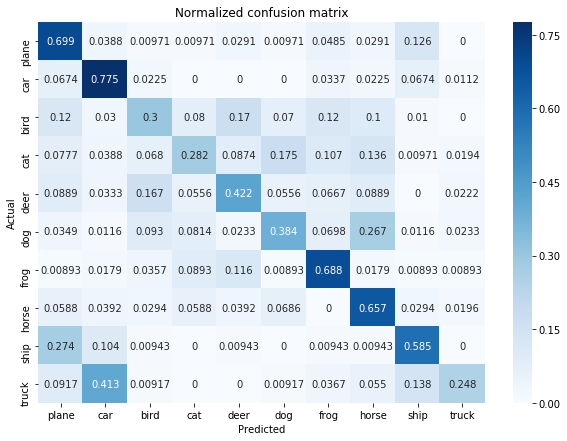

In [117]:
score, train_loss, train_acc, val_loss, val_acc = cnn_main('cnn', Net(), 15, './net/')

In [118]:
results = results.append(score, ignore_index=True)

In [119]:
results

,name,n_features,acc,f1_weighted,precision,recall,fit_time,pred_time
0,linear_10%,1,0.173,0.108780,0.093707,0.173,0.378837,0.066484
1,linear_30%,2,0.243,0.204832,0.188061,0.243,0.376556,0.075434
2,linear_50%,4,0.273,0.240834,0.246297,0.273,0.400816,0.072114
3,linear_70%,14,0.330,0.318973,0.324122,0.330,0.680076,0.100885
4,linear_100%,3072,0.373,0.368572,0.373684,0.373,107.140223,17.328828
5,poly,3072,0.355,0.354613,0.357822,0.355,102.133489,17.071837
6,rbf,3072,0.453,0.452319,0.455825,0.453,139.674481,18.058136
7,baseline_cnn,,0.477,0.460633,0.477839,0.477,66.115435,0.326117
8,cnn,,0.504,0.487737,0.517606,0.504,92.583278,0.438320


Text(20.625, 0.5, 'loss')

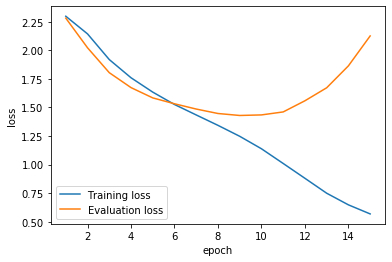

In [120]:
sns.lineplot(x=range(1,len(train_loss)+1), y=train_loss, label='Training loss')
sns.lineplot(x=range(1,len(train_loss)+1), y=val_loss, label='Evaluation loss')
plt.savefig('./net/loss.png')
plt.xlabel('epoch')
plt.ylabel('loss')

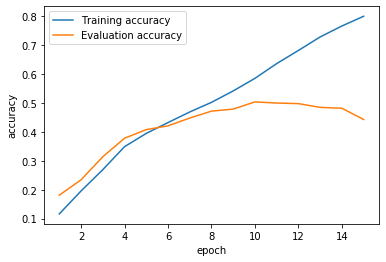

In [121]:
sns.lineplot(x=range(1,len(train_loss)+1), y=train_acc, label='Training accuracy')
sns.lineplot(x=range(1,len(train_loss)+1), y=val_acc, label='Evaluation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('./net/acc.png')

Text(0, 0.5, 'accuracy')

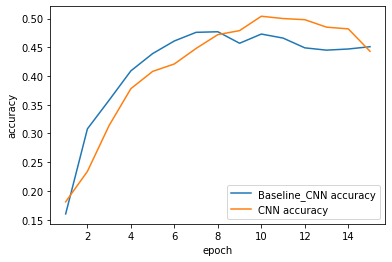

In [128]:
sns.lineplot(x=range(1,len(train_loss)+1), y=b_val_acc, label='Baseline_CNN accuracy')
sns.lineplot(x=range(1,len(train_loss)+1), y=val_acc, label='CNN accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

## Task 4

For task 2 and task 3 compare and contrast
- performances (accuracy, precision, recall, f1)
- computational complexity (time)
- level of overfitting 

which one is better under certain situations and explain why

In [122]:
results

,name,n_features,acc,f1_weighted,precision,recall,fit_time,pred_time
0,linear_10%,1,0.173,0.108780,0.093707,0.173,0.378837,0.066484
1,linear_30%,2,0.243,0.204832,0.188061,0.243,0.376556,0.075434
2,linear_50%,4,0.273,0.240834,0.246297,0.273,0.400816,0.072114
3,linear_70%,14,0.330,0.318973,0.324122,0.330,0.680076,0.100885
4,linear_100%,3072,0.373,0.368572,0.373684,0.373,107.140223,17.328828
5,poly,3072,0.355,0.354613,0.357822,0.355,102.133489,17.071837
6,rbf,3072,0.453,0.452319,0.455825,0.453,139.674481,18.058136
7,baseline_cnn,,0.477,0.460633,0.477839,0.477,66.115435,0.326117
8,cnn,,0.504,0.487737,0.517606,0.504,92.583278,0.438320


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

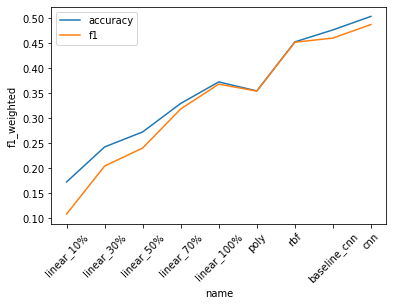

In [123]:
sns.lineplot(x='name', y='acc', data=results, sort=False, label='accuracy')
sns.lineplot(x='name', y='f1_weighted', data=results, sort=False, label='f1')

plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

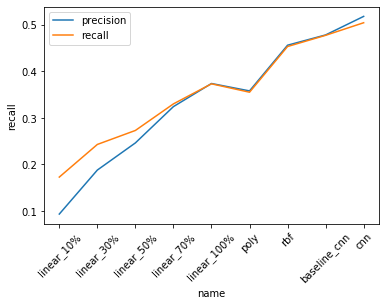

In [124]:
sns.lineplot(x='name', y='precision', data=results, sort=False, label='precision')
sns.lineplot(x='name', y='recall', data=results, sort=False, label='recall')

plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

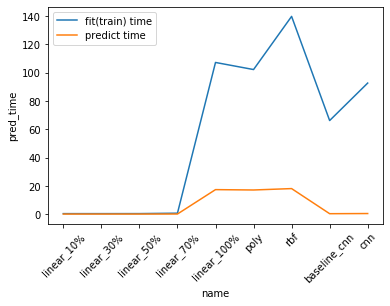

In [125]:
sns.lineplot(x='name', y='fit_time', data=results, sort=False, label='fit(train) time')
sns.lineplot(x='name', y='pred_time', data=results, sort=False, label='predict time')

plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

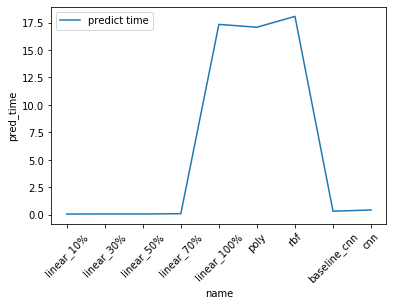

In [126]:
sns.lineplot(x='name', y='pred_time', data=results, sort=False, label='predict time')
plt.xticks(rotation=45)